## Project Title: Time-Series Anomaly Detection
***
### Description: 
On the keras website, there is an example of time-series anomaly detection. Re-create this example in a notebook of your own, explaining the concepts. Clearly explain each keras function used, referring to the documentation. Include an introduction to your notebook, setting the context and describing what the reader can expect as they read down through the notebook. Include a conclusion section where you suggest improvements you could make to the analysis in the notebook.

### Introduction:
Time-series anomaly detection is the finding of unexpected deviances from what would be expected from a particular metric over a length of time, this may be in hours, days or some other length of time. The normal behaviour of an input or metric must be known before anomalies can be accurately detected. A line graph of a time-series shows repeated patterns such as a wave or else a less smooth jagged output. A straight line would mean there is no change in the metric over a time span. 

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
# import tensorflow.keras as keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

The Numenta Anomaly Benchmark (NAB) framework was introduced by Numenta in 2015. It is open source and therefore publicly available. It can be used to assess anomaly detection algorithms for detecting anomalies in streaming data. 

The Numenta Anomaly Benchmark(NAB) dataset is used here: https://www.kaggle.com/datasets/boltzmannbrain/nab It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.
The NAB dataset has of 58 timeseries data files, comprised of both real-world and artifical timeseries data. All files contain anomalies, unless otherwise noted.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
# Reading in the csv file using Python's pandas package. 'parse_dates=True' parses a column or index to date data types (convert
# to a datetime object). 'index_col' will set the index column to whatever column you want:
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


Visualize the data:
Timeseries data without anomalies. We will use the following data for training.

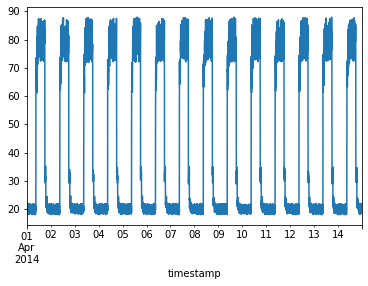

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

Timeseries data with anomalies:

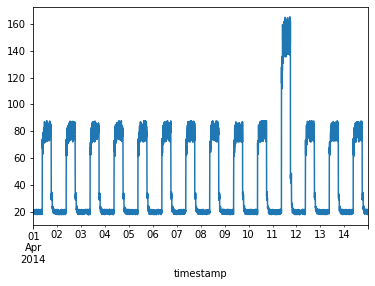

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [ ]:
Prepare training data:

In [4]:
# Normalize and save the mean and std we get, for normalizing test data. Normalization is done to ensure variables are of a 
# similar scale.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
# 'z-score' normalization technique is used here. The mean of all the values is zero and the standard deviation is one:
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


Creating sequences:

In [5]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


Build a model:

Convolutional Neural Networks:
The convolution layer is used to build a convolutional neural network (CNN). The operation known as a "convolution" is a linear operation that involves the multiplication of a set of weights with the input. "The multiplication is performed between an array of input data and a two-dimensional array of weights, called a filter or a kernel."

"The filter is smaller than the input data and the type of multiplication applied between a filter-sized patch of the input and the filter is a dot product. A dot product is the element-wise multiplication between the filter-sized patch of the input and filter, which is then summed, always resulting in a single value. Because it results in a single value, the operation is often referred to as the “scalar product“."
"Using a filter smaller than the input is intentional as it allows the same filter (set of weights) to be multiplied by the input array multiple times at different points on the input. Specifically, the filter is applied systematically to each overlapping part or filter-sized patch of the input data, left to right, top to bottom. This systematic application of the same filter across an image is a powerful idea. If the filter is designed to detect a specific type of feature in the input, then the application of that filter systematically across the entire input image allows the filter an opportunity to discover that feature anywhere in the image. This capability is commonly referred to as translation invariance, e.g. the general interest in whether the feature is present rather than where it was present."
https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/#:~:text=Convolutional%20layers%20are%20the%20major,that%20results%20in%20an%20activation.

In [9]:
x_train.shape[1]

288

In [10]:
x_train.shape[2]

1

The Sequential class in keras groups a linear stack of layers into a keras model:

---
---

### <i>One-dimensional convolution layer:</i>

Convolution is the process of sliding a kernel over an input signal. A kernel is like a two-dimensional window that moves through the layers of a network after every convolution. It can be done either via non casual convolution (cross-correlation) or casual convolution. In non-casual the output is dependent on the future input. The output from a convolutional layer may have a depth greater than one, this can be flattened to reduce the depth to make it suitable for inputting into another layer.

It creates a convolution kernel that is convoled with the layer input over one spatial dimension, producing a tensor of outputs. Convolution layers have different properties to other layers. "Convolutional layers are used in convolutional neural networks. A convolution is the application of a filter to output what is called an 'activation'." 
Using the same filter on an input results in a map of activations. https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/#:~:text=Convolutional%20layers%20are%20the%20major,that%20results%20in%20an%20activation.

'filters' is the number of dimensions of the output space, 'padding' can be either "valid" or "same", where valid means no padding and same ensures the output has the same height/width dimensionality as the input. 'activation' is the activation function to be used, here "relu" is the rectified linear unit activation function. This returns the maximum of 0 and the 
input tensor. An activation function may be linear or non linear. A neural network can learn mappings from the activation function. It can take in parameters: x, the input variable; alpha, a floating point number to set the slope for values 
lower than the threshold; max_value, a float that sets the largest value the function can return; threshold, a float to set which values will be set to zero. kernel-size' is the length of the convolution window. It returns a Tensor of same shape and dtype as the input, x. 'Cov1DTranspose' returns a Tensor of rank 3. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1DTranspose

![relu activation function](https://atcold.github.io/pytorch-Deep-Learning/images/week11/11-1/ReLU.png)

Dropouts: prevent overfitting. Noise in training data is learned by a model which don't apply to new data and affect a models ability to generalize. A dropout rate can be specified to decide what percentage of neurons are going to be ignored during training, this group will temporarily not contribute to activiting neurons in the next layer. Dropouts change how weights of neurons are updated during backpropagation. Without applying a dropout, the validation loss will stop decreasing after a certain number of epochs.

In [6]:
# Build a model:
model = keras.Sequential(
    [
        # Only the first layer can receive an optional 'input-shape' argument. If the shape is specified, the model gets built continuously as you add layers:
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        # The padding set to "same" makes the output length the same as the input length. In "valid" mode the output length is not 
        # equal to the input length.
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        # '.Dropout' sets the rate at which inputs will be set to zero. "Inputs not set to 0 are scaled up by 1/(1 - rate) such
        # that the sum over all inputs is unchanged." Its other arguments are: noise_shape and seed. 'noise_shape' is "the shape of
        # the binary dropout mask that will be multiplied with the input." and 'seed' can be an integer used as a random seed. 
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
# Configuring the model using '.compile()'. 'loss' is the loss function which may be a string or a `tf.keras.losses.Loss` instance. A loss
# function is of the form fn(y_true, y_pred), where y_true are the actual values and y_pred are the model's predictions. Here the optimizer
# is the Adam algorithm.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

Fitting the Autoencoder model using the training data (x_train) both as input and output data. This is the normalized dataset. The validation data has both normal and anomaly data points:

---
---

The training set 'x_train' is used as both input and output. 'batch_size' defaults to 32, it gives the number of samples per 
gradient. 'epochs' specifies the number of iterations through the input and output data. It is trained until the epoch of index 
epochs is reached. 'validation_split' specifies the percentage of the training data to be used as validation data. Validation 
data is used by the model to calculates any losses and other metrics at the end of each epoch. The validation data is not trained
by the model, but it is kept aside and is compared with the training data after it is trained. A keras callback instance called 'EarlyStopping' is used.
It lets a user specify the number of training epochs and end the training when the model stops improving. 'val_loss' is the loss
on the validation dataset. Calculations carried out on the validation dataset will have the prefix 'val_'. Setting mode to equal
'min' implies that the objective is to decrease. The 'patience' arguements allows a user to specify how many epochs the model
should go through before stopping, when the epochs are no longer improving:

Keras keeps a 'history' object which store loss values and other metrics in memory. 'model.fit' creates this history object.

*loss values* are the difference between what the values should be, and the values predicted by Keras after each epoch. The aim is to minimize the loss values.

We can see below the training losses reduce after each epoch, while the validation loss begins to fluctuate. The testing loss decreases very rapidly in the beginning, then it decrease slightly when the number of epochs increases. This is normal and is a good sign. The testing loss is still decreasing up to 20 epochs which means the model is not overfitting and that more epochs could be run through.

In [7]:
history = model.fit(
    # The input variable:
    x_train,
    # This is 'y' the target variables to be predicted:
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 8s 283ms/step - loss: 0.6683 - val_loss: 0.0930
Epoch 2/50
27/27 [==============================] - 5s 198ms/step - loss: 0.0968 - val_loss: 0.0432
Epoch 3/50
27/27 [==============================] - 5s 197ms/step - loss: 0.0621 - val_loss: 0.0366
Epoch 4/50
27/27 [==============================] - 5s 198ms/step - loss: 0.0516 - val_loss: 0.0319
Epoch 5/50
27/27 [==============================] - 5s 198ms/step - loss: 0.0455 - val_loss: 0.0294
Epoch 6/50
27/27 [==============================] - 5s 200ms/step - loss: 0.0409 - val_loss: 0.0280
Epoch 7/50
27/27 [==============================] - 6s 206ms/step - loss: 0.0373 - val_loss: 0.0264
Epoch 8/50
27/27 [==============================] - 5s 203ms/step - loss: 0.0340 - val_loss: 0.0254
Epoch 9/50
27/27 [==============================] - 6s 208ms/step - loss: 0.0309 - val_loss: 0.0238
Epoch 10/50
27/27 [==============================] - 5s 201ms/step - loss: 0.0286 - val_loss: 0.0242

In [19]:
history

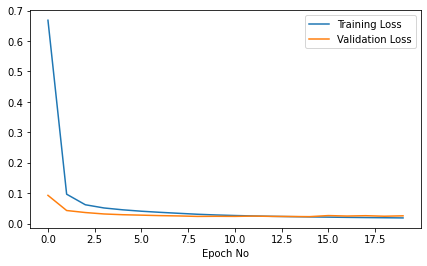

In [20]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.rcParams["figure.figsize"] = (7,4)
plt.xlabel('Epoch No')
plt.legend()
plt.show()

*MAE loss* is the mean absolue error loss, or the average of the differences between the actual values and the predicted values.

Detecting anomalies:

Keras data can simultaneously be used for classification and regression predictions using the ```model.predict``` method.<br>
It can also be used to load a previously constructed and saved model, for example ```reconstructed_model.predict()``` or ```reconstructed_model = keras.models.load_model("x_model") ```

Reconstructing losses and metrics:<br>```np.testing.assert_allclose(model.predict(x_train), reconstructed_model.predict(x_train)```

118/118 [==============================] - 4s 32ms/step


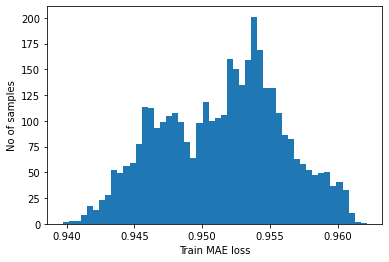

Reconstruction error threshold:  0.962169770886117


In [7]:
# Get train MAE loss:
# x_train_pred = model.predict(x_train, batch_size=None, verbose=0, steps=None, callbacks=None)
x_train_pred = model.predict(x_train, verbose=1)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

3/3 [==============================] - 2s 553ms/step


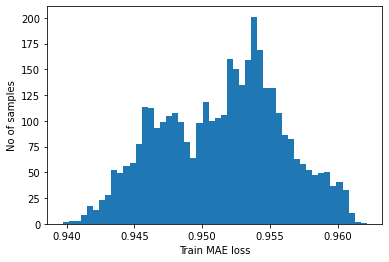

Reconstruction error threshold:  0.962169770886117


In [8]:
# Get train MAE loss:
# x_train_pred = model.predict(x_train, batch_size=None, verbose=0, steps=None, callbacks=None)
x_train_pred = model.predict(x_train, verbose=1, steps=3)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Compare reconstruction:

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

Prepare test data:

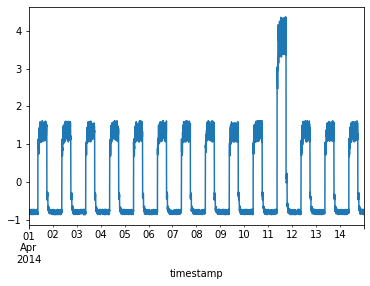

Test input shape:  (3745, 288, 1)


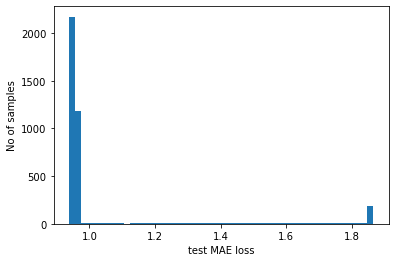

Number of anomaly samples:  936
Indices of anomaly samples:  (array([ 736,  737,  739,  740,  741,  742,  743,  744,  745,  746,  747,
        748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,
        759,  760,  761,  762,  763,  764,  765,  766,  767,  768,  769,
        770,  771,  772,  773,  774,  775,  776,  777,  778,  779,  780,
        781,  782,  783,  784,  785,  786,  787,  788,  789,  790,  791,
        792,  793,  794,  795,  796,  797,  798,  799,  800,  801,  802,
        803,  804,  805,  806,  807,  808,  809,  810,  811,  812,  813,
        814,  815,  816,  817,  818,  819,  820,  821,  822,  823,  824,
        825,  826,  827,  828,  829,  830,  831,  832,  833,  834,  835,
        836,  837,  838,  839,  840,  841,  842,  843,  844,  845,  846,
        847,  848,  849,  850,  851,  852,  853,  854,  855,  856,  857,
        858,  859,  860,  861,  862,  863,  864,  865,  866,  867,  868,
        869,  870,  871,  872,  873,  874,  875,  876,  877,  

In [9]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Plot anomalies:

In [10]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

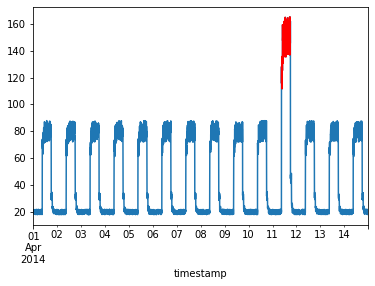

In [11]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()